**Varsha Yarram and Michelle Phan**

Fall 2024

CS 343: Neural Networks

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

plt.show()
plt.style.use(['seaborn-v0_8-colorblind', 'seaborn-v0_8-darkgrid'])
plt.rcParams.update({'font.size': 16})

np.set_printoptions(suppress=True, precision=3)

# Automatically reload external modules
%load_ext autoreload
%autoreload 2

## TensorFlow install test

*Sanity check that TensorFlow is installed correctly:*

Executing the following cell should print 3 

In [2]:
tf.print(tf.reduce_sum([tf.constant(1), tf.constant(2)]))

3


# Project 4 | Transfer Learning

## Task 1: Implement ConvNet4AccelV2 in TensorFlow

Construct the familiar `ConvNet4AccelV2` neural network architecture from last project in TensorFlow's high level `Keras::Sequential` API. Also like your last project, train on the STL-10 training set and test on the STL-10 test set.

### 1a. Use the high level `Keras::Sequential` API in TensorFlow to implement the architecture of ConvNet4AccelV2 from the last project. Train and test your network on the STL-10 dataset. 

**Goal:** Achieve ≥ 47% on either the validation set or test set. *For our purposes, getting ≥ 47% validation accuracy at any point during training is enough (i.e. doesn't need to be at the very end of training).*

#### Notes

- You should use the usual STL-10 data acquisition and preprocessing code from your last project. You can use the default split, or modify it yourself.
- You don't need to do a hyperparameter search. Values that worked on the CNN project should get you in the ballpark here. The goal is to show that you know how to put together a `keras::Sequential` model and have it work successfully.
- You may have to tweak the hyperparameters by hand a little (number of epochs, regularization, number of hidden units, etc.) to hit your accuracy target, but it should not take too much effort.
- TensorFlow needs the RGB color channel AFTER the spatial dimensions. For example: (32, 32, 3), not (3, 32, 32). You may therefore need to slightly modify the preprocesssing pipeline for this project.

#### Keras Sequential workflow

Recall the `Keras::Sequential` common workflow:

- Build structure of network with `Keras::Sequential`.
- Compile network with your choice of optimizer, loss, and metrics.
- Fit the model (remembering to pass in the appropriate training and validation sets). This results a history object that can be used to examine training/validation accuracy and loss.
- Evaluate the model on the test set. This returns test loss and accuracy.

#### Helpful documentation

These documentation pages should be helpful:
- https://www.tensorflow.org/api_docs/python/tf/keras/Sequential
- https://www.tensorflow.org/api_docs/python/tf/keras/Model#compile
- https://www.tensorflow.org/api_docs/python/tf/keras/Model#evaluate
- https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit
- https://www.tensorflow.org/api_docs/python/tf/keras/Model#summary

In [3]:
import load_stl10_dataset, preprocess_data
from preprocess_data import preprocess_stl

In [120]:
classes = np.loadtxt(os.path.join('data', 'stl10_binary', 'class_names.txt'), dtype=str)

load_stl10_dataset.purge_cached_dataset()

# YOUR CODE HERE
x_train, y_train, x_test, y_test, x_val, y_val, x_dev, y_dev = preprocess_data.load_stl10(
    n_train_samps=4000, n_test_samps=495, n_valid_samps=495, n_dev_samps=10, scale_fact=3)

#Fix the data shapes
x_train = np.transpose(x_train, (0,2,3,1))
x_val = np.transpose(x_val, (0,2,3,1))
x_test = np.transpose(x_test, (0,2,3,1))
x_dev = np.transpose(x_dev, (0,2,3,1))
print ("New Shapes:")
print ('Train data shape: ', x_train.shape)
print ('Train labels shape: ', y_train.shape)
print ('Test data shape: ', x_test.shape)
print ('Test labels shape: ', y_test.shape)
print ('Validation data shape: ', x_val.shape)
print ('Validation labels shape: ', y_val.shape)
print ('dev data shape: ', x_dev.shape)
print ('dev labels shape: ', y_dev.shape)


Images are: (5000, 96, 96, 3)
Labels are: (5000,)
Resizing 5000 images to 32x32...Done!
Saving Numpy arrays the images and labels to ./numpy...Done!
New Shapes:
Train data shape:  (4000, 32, 32, 3)
Train labels shape:  (4000,)
Test data shape:  (495, 32, 32, 3)
Test labels shape:  (495,)
Validation data shape:  (495, 32, 32, 3)
Validation labels shape:  (495,)
dev data shape:  (10, 32, 32, 3)
dev labels shape:  (10,)


In [121]:
tf.random.set_seed(0)

# YOUR CODE HERE
img_y, img_x = x_train.shape[1], x_train.shape[2]
n_chans = x_train.shape[3]

model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(shape=(img_y, img_x, n_chans)),
    tf.keras.layers.Conv2D(filters=16,kernel_size=7, activation='linear', strides=1,padding='valid'),
    tf.keras.layers.MaxPool2D(pool_size=(2,2),strides=None,padding='same'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=100,activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.Dropout(rate=0.3),
    tf.keras.layers.Dense(units=100,activation='softmax')
])
model.summary()


Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 26, 26, 16)     │         2,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 13, 13, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_13 (Flatten)            │ (None, 2704)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 100)            │       270,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 100)            │        10,100 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 282,968 (1.08 MB)

 Trainable params: 282,968 (1.08 MB)

 Non-trainable params: 0 (0.00 B)

In [6]:
model.compile(optimizer='adamw',
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])


In [7]:
hist = model.fit(x_train, y_train, batch_size = 700, epochs = 30, validation_data=(x_val,y_val),verbose=2)


Epoch 1/30
6/6 - 2s - 250ms/step - accuracy: 0.1285 - loss: 5.5293 - val_accuracy: 0.2364 - val_loss: 4.2944
Epoch 2/30
6/6 - 0s - 40ms/step - accuracy: 0.2160 - loss: 4.5134 - val_accuracy: 0.2545 - val_loss: 3.8758
Epoch 3/30
6/6 - 0s - 47ms/step - accuracy: 0.2477 - loss: 4.0408 - val_accuracy: 0.2909 - val_loss: 3.6586
Epoch 4/30
6/6 - 0s - 41ms/step - accuracy: 0.2800 - loss: 3.6872 - val_accuracy: 0.2949 - val_loss: 3.3930
Epoch 5/30
6/6 - 0s - 40ms/step - accuracy: 0.3072 - loss: 3.3815 - val_accuracy: 0.2990 - val_loss: 3.1636
Epoch 6/30
6/6 - 0s - 41ms/step - accuracy: 0.3300 - loss: 3.1404 - val_accuracy: 0.3293 - val_loss: 2.9714
Epoch 7/30
6/6 - 0s - 42ms/step - accuracy: 0.3492 - loss: 2.9294 - val_accuracy: 0.3515 - val_loss: 2.8164
Epoch 8/30
6/6 - 0s - 44ms/step - accuracy: 0.3735 - loss: 2.7292 - val_accuracy: 0.3798 - val_loss: 2.6521
Epoch 9/30
6/6 - 0s - 44ms/step - accuracy: 0.3885 - loss: 2.5681 - val_accuracy: 0.3737 - val_loss: 2.5289
Epoch 10/30
6/6 - 0s - 55ms

### 1b. Make 2 "high quality" plots showing the following

- Training and validation accuracy (y axis) over training epochs (x axis).
- Training and validation loss (y axis) over epochs (x axis).

A high quality plot consists of:
- A useful title
- X and Y axis labels
- A legend

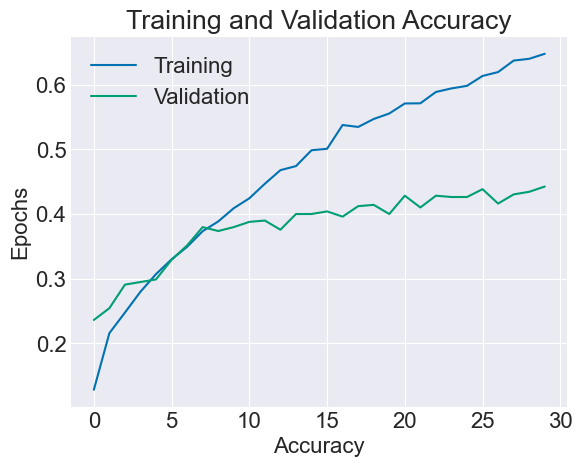

In [8]:
# YOUR CODE HERE
train_acc_plt = plt.plot(hist.history['accuracy'], label="Training")
val_acc_plt = plt.plot(hist.history['val_accuracy'], label="Validation")
plt.legend()
plt.title("Training and Validation Accuracy")
plt.xlabel("Accuracy")
plt.ylabel("Epochs")
plt.show()


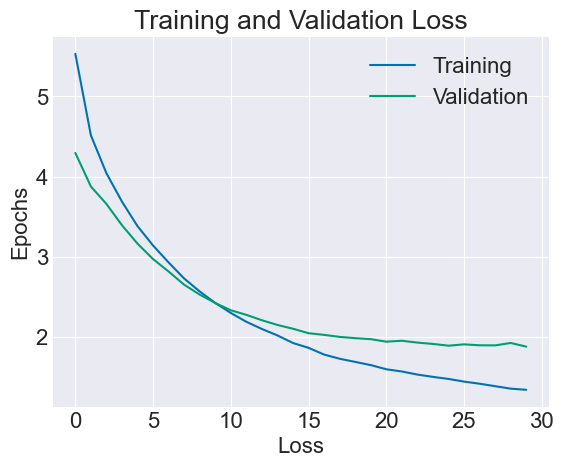

In [9]:
train_loss_plt = plt.plot(hist.history['loss'], label="Training")
val_loss_plt = plt.plot(hist.history['val_loss'], label="Validation")
plt.legend()
plt.title("Training and Validation Loss")
plt.xlabel("Loss")
plt.ylabel("Epochs")
plt.show()

### 1c. Visualize predictions

Make a 5x5 grid of the first 25 images in the test dataset. Label each with the predicted class label string (English label, not an int code).

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7126440442473139..2.4272643746996563].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8415566808988504..2.1150487992726985].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9167524147108064..0.8765783942191577].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9329094329800773..2.341401562899807].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.038458709770312..2.521059322279579].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.737555830396767..2.507503524842526].
Clipping input data to the 

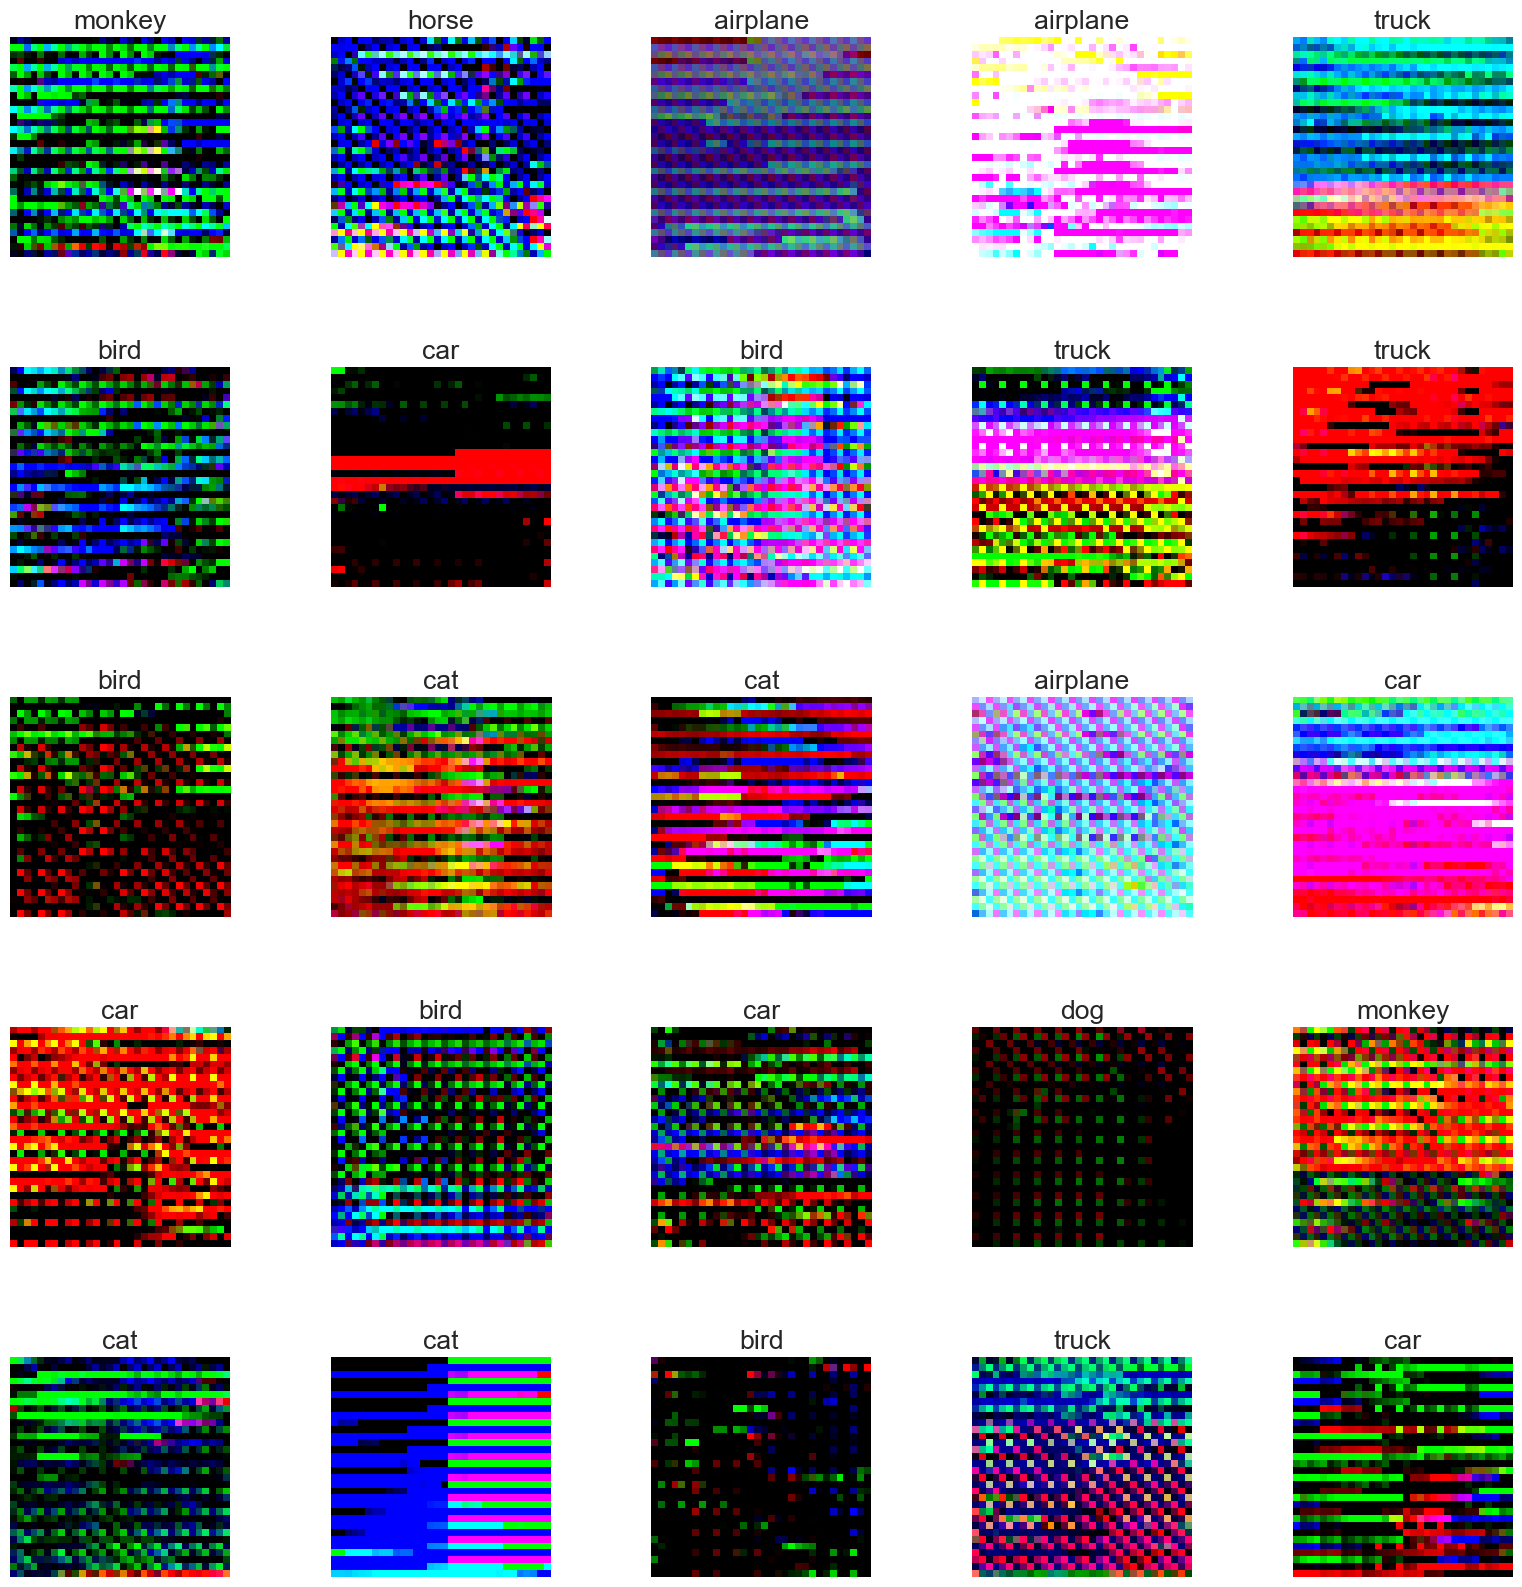

In [10]:
# YOUR CODE HERE
classes = np.loadtxt(os.path.join('data', 'stl10_binary', 'class_names.txt'), dtype=str)
predicted_classes = np.argmax(model.predict(x_test), axis=1)

plt.figure(figsize=(20,20))
plt.subplots_adjust(hspace=0.5)
for n in range(25):
  plt.subplot(5,5,n+1)
  plt.imshow(x_test[n])
  plt.title(classes[predicted_classes[n]])
  plt.axis('off')
plt.show()

### 1d. Questions

**Question 1:** What accuracy do you get on the STL-10 test set? Briefly summarize any non-default hyperparameters that you used to obtain this result.

**Question 2:** How do the loss and accurary results compare to the CNN project?

**Question 3:** Identify a few misclassifications. Is there a discernable pattern?

**Answer 1:**

The accuracy I achieved was accuracy 0.6475 and the loss was 1.3433. I used a reugalirization strength of 0.01 and, a dropout rate of 0.3, a mini-batch size of 700, and ran it over 30 epochs.


**Answer 2:**

The loss is lower than in the CNN project, and the accuracy is higher.

**Answer 3:**

All of the images are pretty noisy, so I am unable to discern any patterns or misclassifications.

## Task 2: Transfer learning

Here you will use TensorFlow to download the pre-trained MobileNetV2 network (you may also use another network like InceptionV3, VGG19, or EfficientNet, but MobileNetV2 likely will run noticeably faster on your machine). We will use transfer learning to accelerate training to solve a novel problem: **the binary classification task of discriminating whether an image is of a hotdog or not.**

### Overview

- Remove the output layer, add a new Dense output layer.
- Freeze (disable) training on all non-output layers.
- Train the last layer on a food dataset. Assess performance. Plot some example images and their classification below.

### 2a. Download and load in hotdot image dataset

Download the **food dataset** from the project website, copy it into a `data` subfolder in your project directory.

Run the below code to load in the hot-dog-or-not dataset. Check the shapes to ensure everything is loaded in correctly. 

In [100]:
ds_base_dir='data/hot-dog-not-hot-dog/numpy/'

hotdog_train_x = np.load(os.path.join(ds_base_dir, 'train_x.npy'))
hotdog_train_y = np.load(os.path.join(ds_base_dir, 'train_y.npy'))
hotdog_test_x = np.load(os.path.join(ds_base_dir, 'test_x.npy'))
hotdog_test_y = np.load(os.path.join(ds_base_dir, 'test_y.npy'))

print(f'Training hotdog split shape: {hotdog_train_x.shape}. Should be (16000, 96, 96, 3)')
print(f'Test hotdog split shape: {hotdog_test_x.shape}. Should be (4000, 96, 96, 3)')

Training hotdog split shape: (16000, 96, 96, 3). Should be (16000, 96, 96, 3)
Test hotdog split shape: (4000, 96, 96, 3). Should be (4000, 96, 96, 3)


### 2b. Normalize hotdog dataset

Standardize both the train and test dataset according to the **same statistics** computed from the **training set**.

In [101]:
# YOUR CODE HERE
mean_train = np.mean(hotdog_train_x, axis=(0, 1, 2), keepdims=True)
std_train = np.std(hotdog_train_x, axis=(0, 1, 2), keepdims=True)

hotdog_train_x = (hotdog_train_x - mean_train) / std_train
hotdog_test_x = (hotdog_test_x - mean_train) / std_train

### 2c. Create hotdog validation set

Set aside the last 20% of the training set as the validation set

In [ ]:
# YOUR CODE HERE
split_index = int(0.8 * len(hotdog_train_x))
# print(split_index)
hotdog_val_x = hotdog_train_x[split_index:]
hotdog_val_y = hotdog_train_y[split_index:]
hotdog_train_x = hotdog_train_x[:split_index]
hotdog_train_y = hotdog_train_y[:split_index]

# with help from Maddie Puzon
def one_hot(y, num_classes):
    one_hots = np.zeros(shape=(y.size, num_classes))
    one_hots[np.arange(0, y.size), y] = 1
    return one_hots

hotdog_val_yh = one_hot(hotdog_val_y,2)
hotdog_train_yh = one_hot(hotdog_train_y,2)
hotdog_test_yh = one_hot(hotdog_test_y,2)





In [103]:
print(f'Validation hotdog split shape: {hotdog_val_x.shape}. Should be (3200, 96, 96, 3)')
print(f'Training hotdog split shape: {hotdog_train_x.shape}. Should be (12800, 96, 96, 3)')

Validation hotdog split shape: (3200, 96, 96, 3). Should be (3200, 96, 96, 3)
Training hotdog split shape: (12800, 96, 96, 3). Should be (12800, 96, 96, 3)


### 2d. Load in pre-trained MobileNetV2 network.

Load in a pre-trained MobileNetV2 network (look up constructor in [tf.keras.applications](https://www.tensorflow.org/api_docs/python/tf/keras/applications/mobilenet_v2/MobileNetV2) or look at the tutorial from class) and set it to a variable called `model`. Remember to make the network not trainable. Calling the `summary()` method on the network object should show you a table with many rows. The top and bottom rows should be:

    Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
    ┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
    │ input_layer_19      │ (None, 96, 96, 3) │          0 │ -                 │
    │ (InputLayer)        │                   │            │            
                                        
    ├─────────────────────┼───────────────────┼────────────┼───────────────────┤
    │ out_relu (ReLU)     │ (None, 3, 3,      │          0 │ Conv_1_bn[0][0]   │
    │                     │ 1280)             │            │                   │  
                                                                                                  
==================================================================================================

and you should see the following at the bottom:

    Total params: 2,257,984 (8.61 MB)
    Trainable params: 0 (0.00 B)
    Non-trainable params: 2,257,984 (8.61 MB)

In [104]:
# YOUR CODE HERE
model = tf.keras.applications.MobileNetV2(input_shape=(96,96,3), include_top=False)
model.trainable = False
model.summary()


Model: "mobilenetv2_1.00_96"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_15      │ (None, 96, 96, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 48, 48,    │        864 │ input_layer_15[0… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 48, 48,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 48, 48,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 48, 48,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 48, 48,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 48, 48,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 48, 48,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 48, 48,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 48, 48,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 48, 48,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 48, 48,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 49, 49,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 24, 24,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 24, 24,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 24, 24,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 24, 24,    │      2,304 │ block_1_depthwis

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,257,984 (8.61 MB)

### 2e. Create augmented model

Create a new `keras::Sequential` augmented model with an output layer that has the correct number of units to deal with the hot-dog or not problem with your choice of optimizer, an appropriate loss, and metric(s).

#### Helpful links

https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense

https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam

https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/AdamW

https://www.tensorflow.org/api_docs/python/tf/losses

In [114]:
# YOUR CODE HERE
aug_model = tf.keras.Sequential([
    model,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=2, activation='softmax')
])
aug_model.compile(optimizer='adamw', loss='categorical_crossentropy', metrics=['accuracy'])
aug_model.summary()

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_96             │ (None, 3, 3, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_10 (Flatten)            │ (None, 11520)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 2)              │        23,042 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,281,026 (8.70 MB)

 Trainable params: 23,042 (90.01 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

### 2f. Questions

**Question 4:** What is the accuracy and loss for the network with the untrained output layer on the test set? Explain why you got the accuracy value that you did.

**Question 5:** Briefly defend your choice of number of units in the output layer.

**Answer 4:**

I got an accuracy of 0.45375001430511475 and a loss of 1.28477120399475. The accuracy is a little less than 50%, which is what I would expect, since the network is not trained on what a hot dog is or isn't so it has a 50% chance of getting it right.

**Answer 5:**

There are two possiple options for the output: hotdog or not hot dog. So, there are two possible units.

In [111]:
# YOUR CODE HERE
loss, acc = aug_model.evaluate(hotdog_test_x, hotdog_test_yh)
print(f'Accuracy: {acc}, Loss: {loss}')

125/125 ━━━━━━━━━━━━━━━━━━━━ 11s 71ms/step - accuracy: 0.4651 - loss: 1.2662
Accuracy: 0.45375001430511475, Loss: 1.284771203994751


### 2g. Fit the augmented model on the hotdog training data

Setting the verbose optional parameter to 2 will give you helpful printouts of performance on the validation set as it completes every epoch of training.

#### Training goal

You should aim to achieve at least 85% accuracy on the validation set. If everything is set up properly, you should only need to train for a very small number of epochs.


#### Note

If training time is taking much more than a few minutes per epoch on your computer, you could try reducing the number of data samples in train and validation. For example, by default train `N = 12800`. Try `N = 6400` instead. You could do the same for the validation set.

In [116]:
# YOUR CODE HERE
aug_hist = aug_model.fit(hotdog_train_x, hotdog_train_yh, batch_size=25, epochs=10, validation_data=(hotdog_val_x, hotdog_val_yh), verbose = 2)

Epoch 1/10
512/512 - 59s - 116ms/step - accuracy: 0.9488 - loss: 0.2415 - val_accuracy: 0.9013 - val_loss: 0.7986
Epoch 2/10
512/512 - 53s - 103ms/step - accuracy: 0.9571 - loss: 0.2043 - val_accuracy: 0.9034 - val_loss: 0.8000
Epoch 3/10
512/512 - 53s - 104ms/step - accuracy: 0.9663 - loss: 0.1395 - val_accuracy: 0.8891 - val_loss: 1.0337
Epoch 4/10
512/512 - 50s - 98ms/step - accuracy: 0.9687 - loss: 0.1361 - val_accuracy: 0.8847 - val_loss: 1.1418
Epoch 5/10
512/512 - 48s - 94ms/step - accuracy: 0.9702 - loss: 0.1220 - val_accuracy: 0.8316 - val_loss: 2.0815
Epoch 6/10
512/512 - 48s - 94ms/step - accuracy: 0.9780 - loss: 0.0960 - val_accuracy: 0.9009 - val_loss: 0.9219
Epoch 7/10
512/512 - 47s - 91ms/step - accuracy: 0.9777 - loss: 0.1002 - val_accuracy: 0.9041 - val_loss: 0.8982
Epoch 8/10
512/512 - 48s - 93ms/step - accuracy: 0.9787 - loss: 0.0922 - val_accuracy: 0.9103 - val_loss: 0.9189
Epoch 9/10
512/512 - 48s - 93ms/step - accuracy: 0.9855 - loss: 0.0571 - val_accuracy: 0.8953

### 2h. Plot hotdog results

Produce 2 high quality plots showing the following:

- Training and validation loss over epoch.
- Training and validation accuracy over epoch.

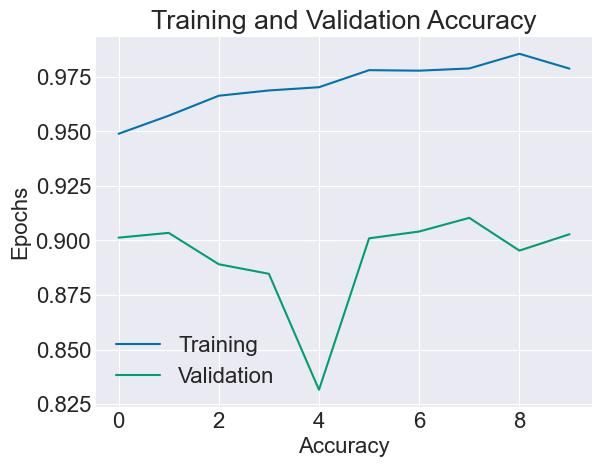

In [122]:
# YOUR CODE HERE
train_acc_plt = plt.plot(aug_hist.history['accuracy'], label="Training")
val_acc_plt = plt.plot(aug_hist.history['val_accuracy'], label="Validation")
plt.legend()
plt.title("Training and Validation Accuracy")
plt.xlabel("Accuracy")
plt.ylabel("Epochs")
plt.show()


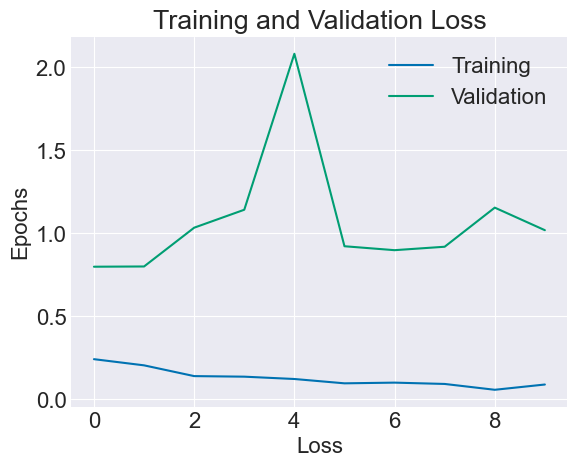

In [123]:
train_loss_plt = plt.plot(aug_hist.history['loss'], label="Training")
val_loss_plt = plt.plot(aug_hist.history['val_loss'], label="Validation")
plt.legend()
plt.title("Training and Validation Loss")
plt.xlabel("Loss")
plt.ylabel("Epochs")
plt.show()

### 2i. Visualize predictions on test set

Use your trained hotdog classifier to get the predicted classes for the first 25 **test set** samples. Then create a 5x5 grid of the first 25 test samples and label each with the predicted class string (English label, not an int code).
- If the prediction is correct, color the label *blue*.
- If the prediction is incorrect, color the label *red*.

**Note:**
- Depending on how you get the network predictions, TensorFlow may give you a vector of class probabilities. This could be shape `(N, 2)` or `(N,)`, depending on the output layer activation function that you used. Remember that if you have these probabilities, you need to recover the predicted class index (e.g. `0`, `1`) before you can label your plots.
- If `imshow` gives you warnings about clipping, check the range of the test samples. If your max is slightly higher than 1, either ignore the warning or divide by the max. 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


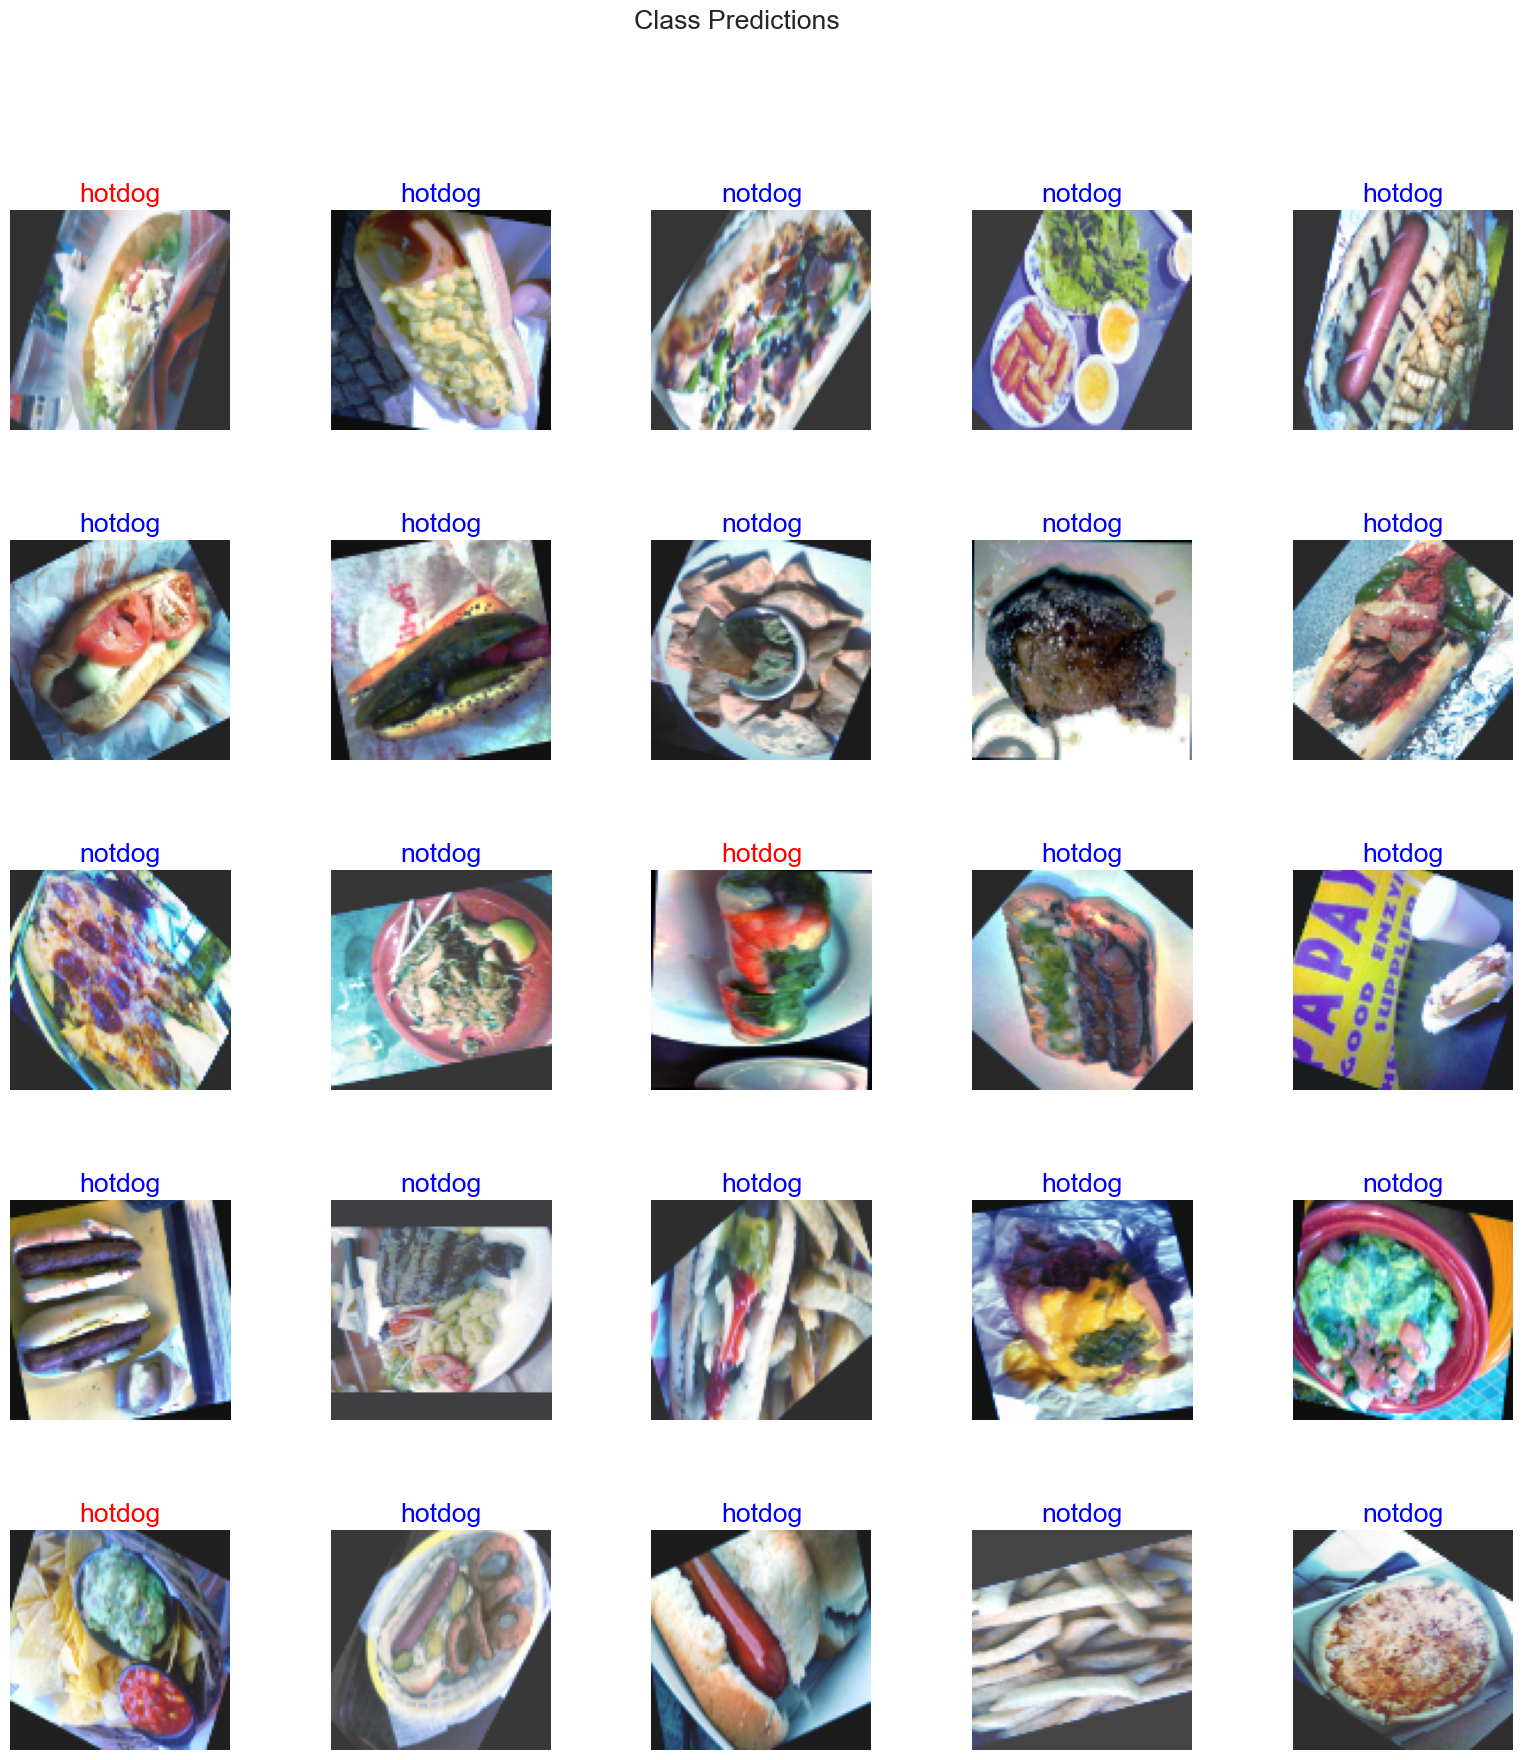

In [ ]:
# YOUR CODE HERE

z_net_act = aug_model.predict(hotdog_test_x[:25])
y_preds = np.argmax(z_net_act, axis=1)
class_names = np.array(["hotdog", "notdog"])
preds = class_names[y_preds]

# Get the true labels for the first 25 test samples (ensure they are integers)
true_labels = hotdog_test_y[:25]


# Plotting
plt.figure(figsize=(20, 20))
plt.subplots_adjust(hspace=0.5)

for n in range(25):
    plt.subplot(5, 5, n + 1)
    positive = hotdog_test_x[n] - np.min(hotdog_test_x)
    rescaled = positive / np.max(positive)
    plt.imshow(rescaled)
    
    # Compare prediction with true label and color accordingly
    color = "blue" if y_preds[n] == true_labels[n] else "red"
    plt.title(preds[n], color=color)
    plt.axis("off")

plt.suptitle("Class Predictions")
plt.show()
